- To run ETL pipeline that cleans data and stores in database
        `python data/process_data.py data/disaster_messages.csv data/disaster_categories.csv data/DisasterResponse.db`
- To run ML pipeline that trains classifier and saves
        `python models/train_classifier.py data/DisasterResponse.db models/classifier.pkl`

# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [46]:
import os
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
import sys
import string
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import seaborn as sns
from numpy import argmax
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
def load_data(file_name):
    path = os.getcwd()+'//data//' + file_name + '.db'
    engine = create_engine('sqlite:///' + path)
    df = pd.read_sql_table(file_name, engine)
    return df

In [48]:
df = load_data('DisasterResponse')

In [49]:
categories = df.iloc[:, 4:].columns

In [50]:
def process_data(dataFrame, categories):
    for category in categories:
        if dataFrame[category].max() > 1:
            print('labels > 1 found in category: "', category, '" rows of that index shall be dropped')
            index_ = dataFrame.loc[dataFrame[category] > 1].index
            dataFrame.drop(index_, inplace = True)
        if dataFrame[category].unique().sum() == 0:
            print('column has no "True" or 1 label: "'+ category + '" this column will be dropped')
            dataFrame.drop(columns=category, inplace=True)
        classes = dataFrame.iloc[:, 4:].columns
    return dataFrame, classes

In [51]:
df, categories = process_data(df, categories)

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(df.message, df.iloc[:,4:], train_size=0.85) 

### 2. Write a tokenization function to process your text data

In [54]:
def tokenize(text):
    url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, "", text).lower().split()
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in text]
    tokens = word_tokenize(' '.join(stripped))
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok)
        clean_tokens.append(clean_tok)

    return clean_tokens
    #return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [55]:
pipeline = pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier())),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001A4C918AF78>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [57]:
y_pred = pipeline.predict(X_test)
y_test = np.array(y_test)

In [58]:
print(classification_report(np.concatenate(y_test), np.concatenate(y_pred)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     80989
           1       0.99      0.94      0.96     10081

    accuracy                           0.99     91070
   macro avg       0.99      0.97      0.98     91070
weighted avg       0.99      0.99      0.99     91070



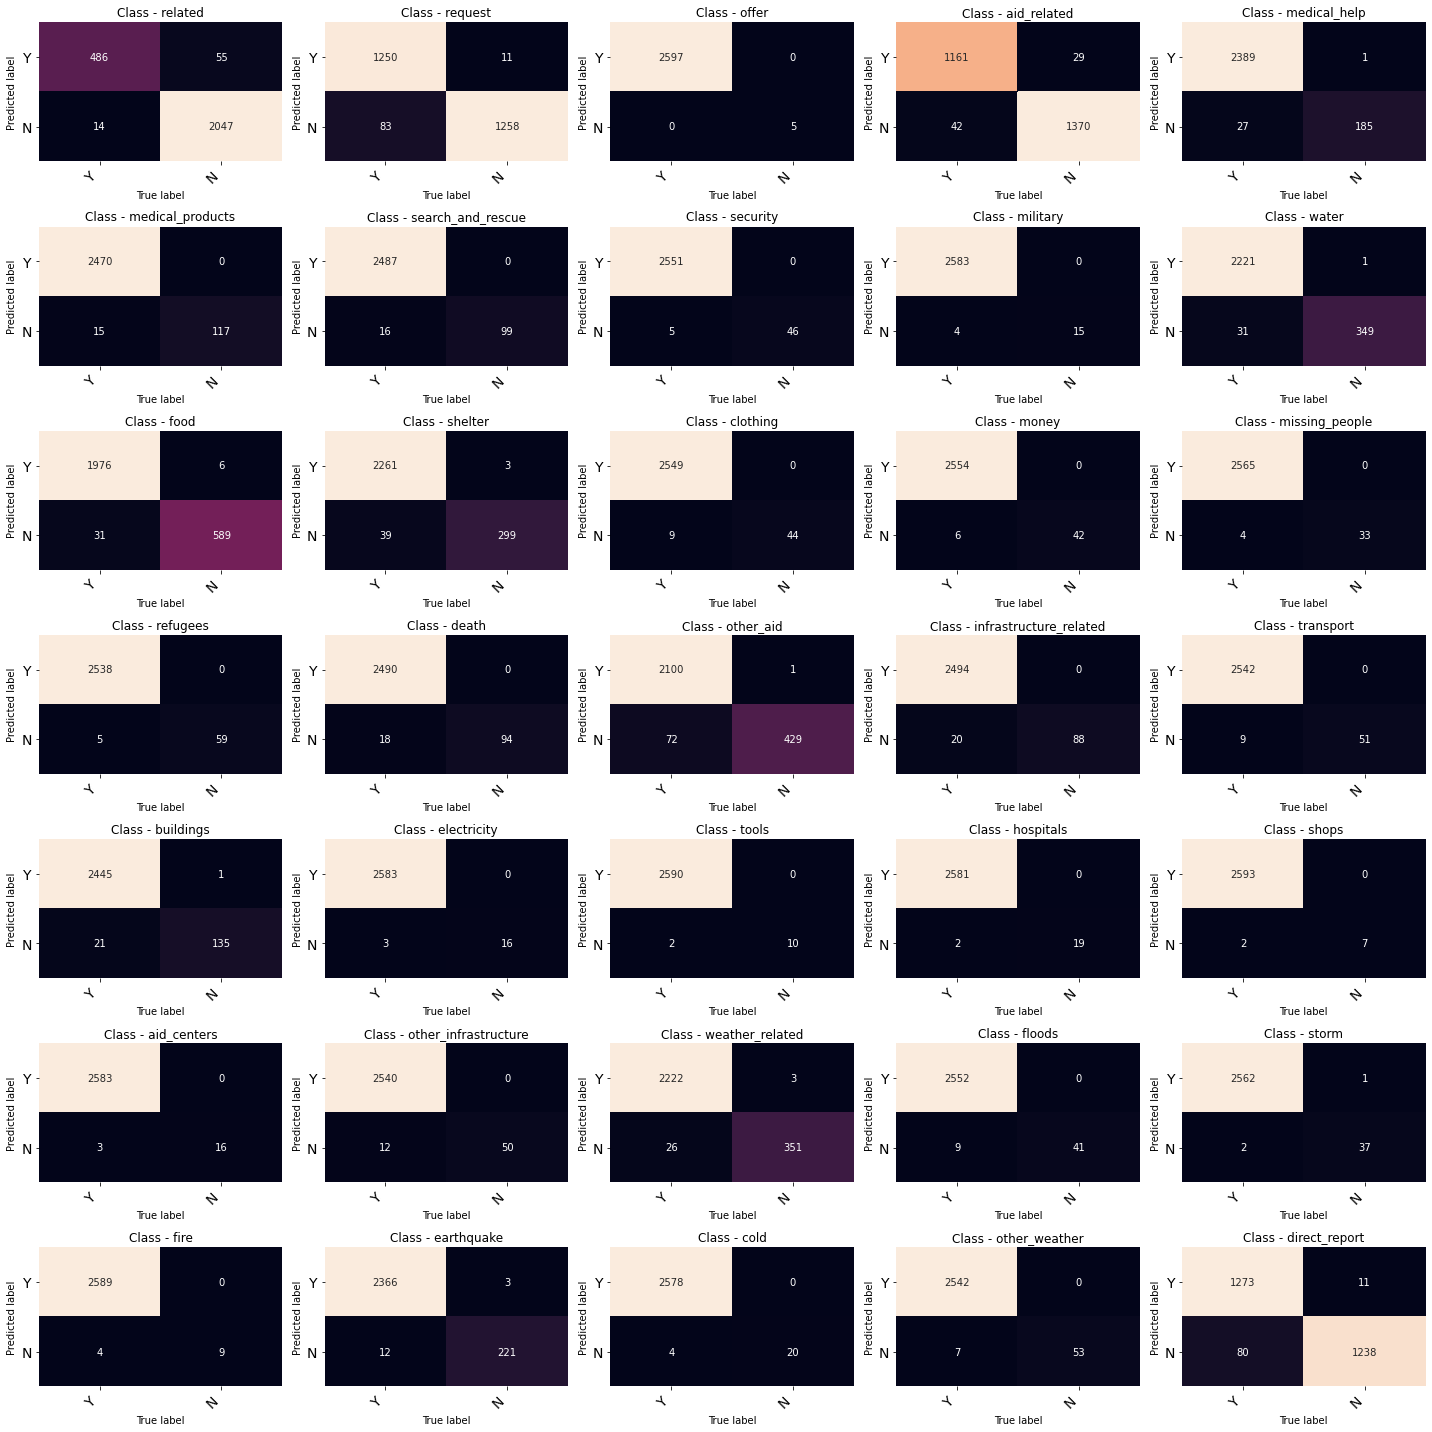

In [59]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Class - " + class_label)
    
confusion_mat = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(7, 5, figsize=(20, 20))
    
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_mat, categories):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show() 

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
pipe2=Pipeline([('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(RandomForestClassifier())),
               ])

In [ ]:
parameters = {
    'tfidf__use_idf': (True, False), #works
    'clf__estimator__n_estimators': [50, 100],
    'clf__estimator__min_samples_split': [2, 3, 4],
    'vect__max_features': (None, 5000, 10000),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),
    }

In [ ]:
cv = GridSearchCV(pipe2, cv=2, param_grid=parameters)

In [ ]:
cv.fit(X_train, y_train)

In [ ]:
y_pred = pipeline.predict(X_test)
y_test = np.array(y_test)
x = classification_report(np.concatenate(y_test), np.concatenate(y_pred))
print(x, y_pred, y_test)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [ ]:
NB_pipeline = Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
                 ])

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.